In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [ ]:
#Kaggle API key
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

import kaggle

In [ ]:
# Download Kaggle dataset (student-por.csv)
kaggle.api.dataset_download_files(dataset='larsen0966/student-performance-data-set', unzip=True)

In [ ]:
# Read dataset to dataframe & display
df = pd.read_csv('./student-por.csv')
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


from matplotlib import pyplot as plt
df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Medu'].plot(kind='hist', bins=20, title='Medu')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Fedu'].plot(kind='hist', bins=20, title='Fedu')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['traveltime'].plot(kind='hist', bins=20, title='traveltime')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('school').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('sex').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('address').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('famsize').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='age', y='Medu', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Medu', y='Fedu', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Fedu', y='traveltime', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='traveltime', y='studytime', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['traveltime']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('traveltime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('school')):
  _plot_series(series, series_name, i)
  fig.legend(title='school', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('traveltime')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['traveltime']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('traveltime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('sex')):
  _plot_series(series, series_name, i)
  fig.legend(title='sex', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('traveltime')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['traveltime']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('traveltime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('address')):
  _plot_series(series, series_name, i)
  fig.legend(title='address', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('traveltime')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['traveltime']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('traveltime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('famsize')):
  _plot_series(series, series_name, i)
  fig.legend(title='famsize', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('traveltime')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
df['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Medu'].plot(kind='line', figsize=(8, 4), title='Medu')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['Fedu'].plot(kind='line', figsize=(8, 4), title='Fedu')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['traveltime'].plot(kind='line', figsize=(8, 4), title='traveltime')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sex'].value_counts()
    for x_label, grp in df.groupby('school')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('school')
_ = plt.ylabel('sex')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['address'].value_counts()
    for x_label, grp in df.groupby('sex')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('sex')
_ = plt.ylabel('address')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['famsize'].value_counts()
    for x_label, grp in df.groupby('address')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('address')
_ = plt.ylabel('famsize')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Pstatus'].value_counts()
    for x_label, grp in df.groupby('famsize')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('famsize')
_ = plt.ylabel('Pstatus')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['school'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='age', y='school', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['sex'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='age', y='sex', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['address'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='age', y='address', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['famsize'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='age', y='famsize', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


# **STEP 1:**


**1.1.   Selected Dataset**

We chose the "Student Performance Data Set" (SPDS) dataset, which is publicly
available through Kaggle’s dataset repository (Cortez, 2019). At a high level,
the dataset’s features cumulatively reflect each subject’s demography and so-
cial background. Each subject’s record within the dataset also contains variables
conveying characteristics about their school and the grades they received in a
Portuguese language class within certain periods. Of note, the dataset’s descrip-
tion on Kaggle shows that it was initially comprised of two sub-datasets - one
about students in the Portuguese language class and another about students in a
Math class. The following analysis only relates to the Portuguese language class
portion of the dataset, as this was the only sub-dataset found on Kaggle

**1.2 Regulated Domain**

Among other features, each record within the SPDS dataset conveys relevant
data about one Portuguese school student’s (i.e., one subject’s) earned grades
(Cortez, 2019). Given this student-centric data, the dataset can be said to belong
to the Regulated Domain of Education.

**1.3 Count of Observations and Variables**

The SPDS dataset contains 649 observations, with each observation pertaining to
data obtained from one Portuguese school student (Cortez, 2019). Furthermore,
each observation encompasses 33 variables that collectively convey information
about each subject’s demographics, social background, school characteristics, and
grades.

**1.4 Dependent Variables**

Of the 33 variables available in the SPDS dataset, three were selected for use
as dependent variables - "G1", "G2", and "G3" (Cortez, 2019). Each dependent
variable is a quantitative, continuous variable that reflects a student’s grade after a particular school year period (first, second, or third). Specifically, G1 represents
a subject’s grade after the first period of the school year, G2 represents a subject’s
grade after the second period of the school year, and G3 represents a subject’s
grade after the third (and final) period of the school year.

**1.5 Protected Class Variables**

**Four variables in the SPDS dataset** appear to pertain to a protected class that is
legally protected (Cortez, 2019). The specific variables, relevant protected class,
and associated laws or legal precedents are displayed below in "Table 1".


> Table 1 — A table communicating the legally recognized protected class variables found within the SPDS dataset and their associated
legal precedent(s)/law(s).

In [ ]:
#load data into a DataFrame object:
protected_df = pd.DataFrame({
  "Dataset Variable": ["age","famsize","Pstatus","sex"],
  "Protected Class": ["Age","Familial Status","Familial Status","Sex"],
  "Associated Law(s)/Legal Precedent(s)":["Age Discrimination in Employment Act of 1967","Civil Rights Act of 1968","Civil Rights Act of 1968","Equal Pay Act of 1963; Civil Rights Act of 1964, 1991"]
})
protected_df

,Dataset Variable,Protected Class,Associated Law(s)/Legal Precedent(s)
0,age,Age,Age Discrimination in Employment Act of 1967
1,famsize,Familial Status,Civil Rights Act of 1968
2,Pstatus,Familial Status,Civil Rights Act of 1968
3,sex,Sex,Equal Pay Act of 1963; Civil Rights Act of 196...


# **Step 2:**

**2.1**

**2.2**

**2.3**

**2.4 Histograms**

<Axes: title={'center': 'age'}, ylabel='Frequency'>

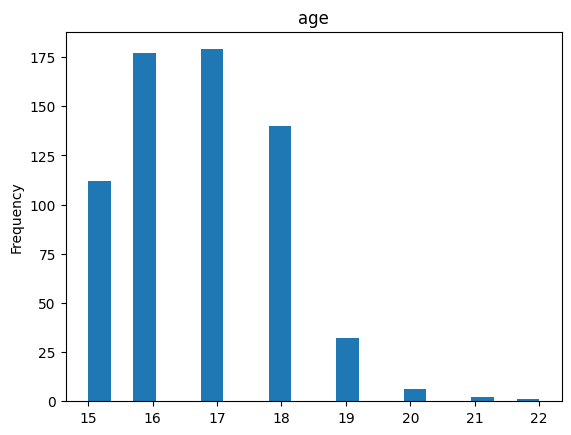

In [24]:
df['age'].plot(kind='hist', bins=20, title='age', )
# for i, value in enumerate(df['age'].value_counts()):
#     plt.text(i, value, str(value))

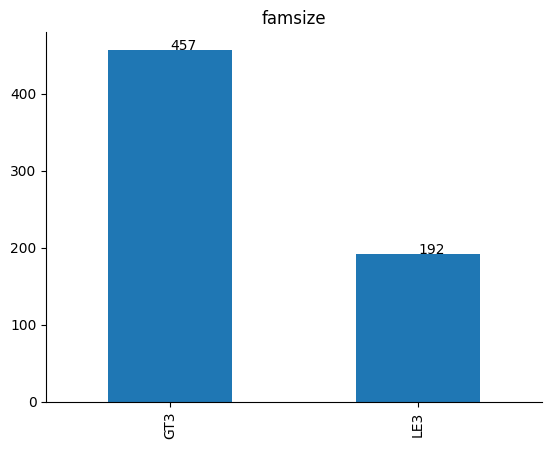

In [25]:
df['famsize'].value_counts().plot(kind='bar', title='famsize')
plt.gca().spines[['top', 'right',]].set_visible(False)
for i, value in enumerate(df['famsize'].value_counts()):
    plt.text(i, value, str(value))

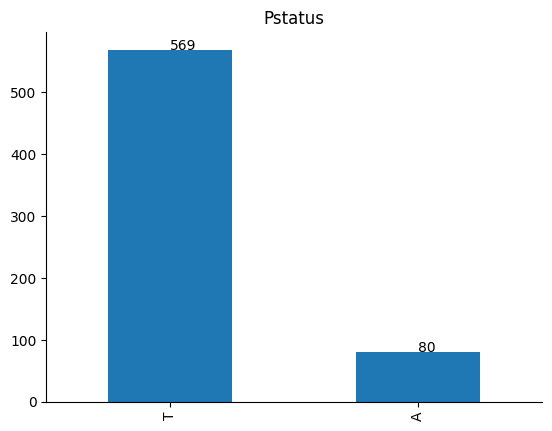

In [26]:
df['Pstatus'].value_counts().plot(kind='bar',  title='Pstatus')
plt.gca().spines[['top', 'right',]].set_visible(False)
for i, value in enumerate(df['Pstatus'].value_counts()):
    plt.text(i, value, str(value))

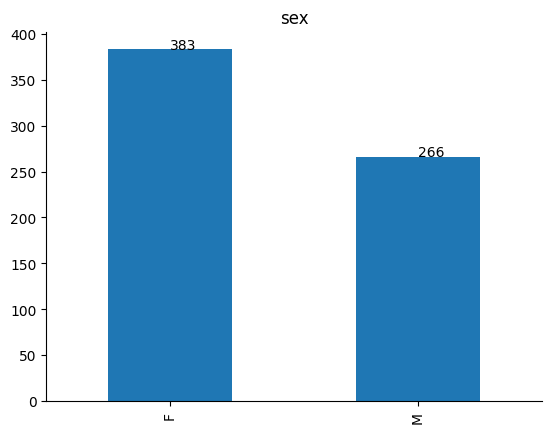

In [27]:
df['sex'].value_counts().plot(kind='bar',  title='sex')
plt.gca().spines[['top', 'right',]].set_visible(False)
for i, value in enumerate(df['sex'].value_counts()):
    plt.text(i, value, str(value))